# 1.) Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
%matplotlib inline


In [4]:
# 🧱 Core PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F


# 🧠 Torchvision for pretrained 3D models
import torchvision
from torchvision import transforms

# 📊 Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 🧪 Scientific stack
import numpy as np
import pandas as pd
import random
import os
import sys

# 📈 Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 🧰 Misc utilities
from tqdm import tqdm

import nibabel as nib  # For loading .nii or .nii.gz files

In [5]:
sys.path.append('/content/drive/MyDrive/BrainAgeRegression')
sys.path.append('/content/drive/MyDrive/BrainAgeRegression/models')

In [6]:
from utils.utils import (
    BrainAgeDataset, set_seed, count_parameters,
    split_dataset, normalize_targets, denormalize
)
from utils.train_utils import BrainAgeTrainer
from utils.eval_utils import BrainAgeEvaluator
from utils.save_utils import BrainAgeSave

# 🔁 Reload if editing utils
import importlib
import utils.train_utils
importlib.reload(utils.train_utils)

import utils.utils
importlib.reload(utils.utils)


# 🧠 Dataset & Metadata
csv_path = '/content/drive/MyDrive/BrainAgeRegression/matched_metadata.csv'
df = pd.read_csv(csv_path)
nifti_dir = '/content/drive/MyDrive/BrainAgeRegression/data/nifti'
full_dataset = BrainAgeDataset(df, nifti_dir)

In [7]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [8]:
model = torchvision.models.video.r3d_18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 2.) Setup + Config

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Add project path
sys.path.append('/content/drive/MyDrive/BrainAgeRegression')

# Paths
model_save_path = "/content/drive/MyDrive/BrainAgeRegression/saved_models/r3d18_transfer"
csv_path = "/content/drive/MyDrive/BrainAgeRegression/matched_metadata.csv"
nifti_dir = "/content/drive/MyDrive/BrainAgeRegression/data/nifti"

# Load Dataset
df = pd.read_csv(csv_path)
full_dataset = BrainAgeDataset(df, nifti_dir, use_normalized_age=False)


# 4.) Normalize / Train/Test / Dataloaders / Criterion / Optimizer

In [10]:
df, mean_age, std_age = normalize_targets(df, target_col='Age')
full_dataset = BrainAgeDataset(df, nifti_dir, use_normalized_age=True)

In [11]:
set_seed(42)
train_dataset, val_dataset, test_dataset = split_dataset(full_dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

In [12]:
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

#5.) Model Load

In [14]:
from torchvision.models.video import r3d_18

model = r3d_18(pretrained=True)

# Modify first conv layer to accept 1 channel instead of 3
model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)

# Replace final FC layer for regression
model.fc = nn.Linear(model.fc.in_features, 1)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 6.) Training Loop

In [15]:
!nvidia-smi


Thu Jul  3 14:07:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   70C    P0             20W /   72W |     333MiB /  23034MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [16]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

stem.0.weight True
stem.1.weight True
stem.1.bias True
layer1.0.conv1.0.weight True
layer1.0.conv1.1.weight True
layer1.0.conv1.1.bias True
layer1.0.conv2.0.weight True
layer1.0.conv2.1.weight True
layer1.0.conv2.1.bias True
layer1.1.conv1.0.weight True
layer1.1.conv1.1.weight True
layer1.1.conv1.1.bias True
layer1.1.conv2.0.weight True
layer1.1.conv2.1.weight True
layer1.1.conv2.1.bias True
layer2.0.conv1.0.weight True
layer2.0.conv1.1.weight True
layer2.0.conv1.1.bias True
layer2.0.conv2.0.weight True
layer2.0.conv2.1.weight True
layer2.0.conv2.1.bias True
layer2.0.downsample.0.weight True
layer2.0.downsample.1.weight True
layer2.0.downsample.1.bias True
layer2.1.conv1.0.weight True
layer2.1.conv1.1.weight True
layer2.1.conv1.1.bias True
layer2.1.conv2.0.weight True
layer2.1.conv2.1.weight True
layer2.1.conv2.1.bias True
layer3.0.conv1.0.weight True
layer3.0.conv1.1.weight True
layer3.0.conv1.1.bias True
layer3.0.conv2.0.weight True
layer3.0.conv2.1.weight True
layer3.0.conv2.1.bias 


🔁 Starting epoch 1/20
✅ First batch loaded from train_loader
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


   🔹 Batch 0: Loss = 1.3700
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])


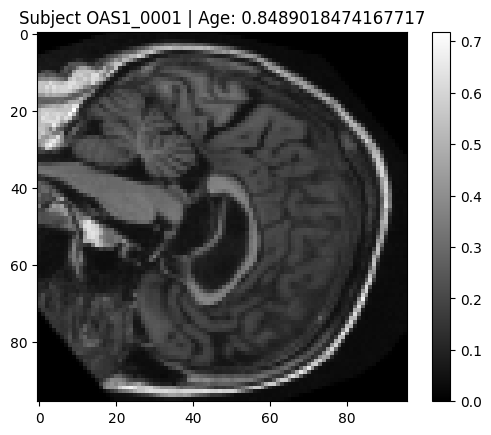

   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔹 Batch 10: Loss = 1.4573
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


📅 Epoch 1/20 | 🏋️ Train Loss: 1.1254 | 🧪 Val Loss: 1.3125
💾 New best val loss: 1.3125 (prev: inf) — saving model

🔁 Starting epoch 2/20
✅ First batch loaded from train_loader
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔹 Batch 0: Loss = 0.5821
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔹 Batch 10: Loss = 1.3858
   🔍 Outp

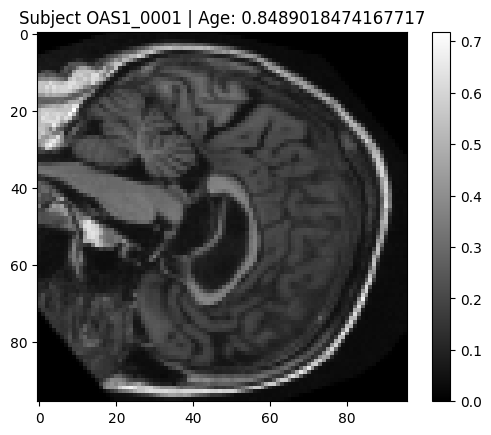

   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔹 Batch 50: Loss = 1.4201
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([3, 1]), Target shape: torch.Size([3])
📅 Epoch 2/20 | 🏋️ Train Loss: 1.1244 | 🧪 Val Loss: 0.9275
💾 New best val loss: 0.9275 (prev: 1.3125) — saving model

🔁 Starting epoch 3/20
✅ First batch loaded from train_loader
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔹 Batch 0: Loss = 1.0600
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 O

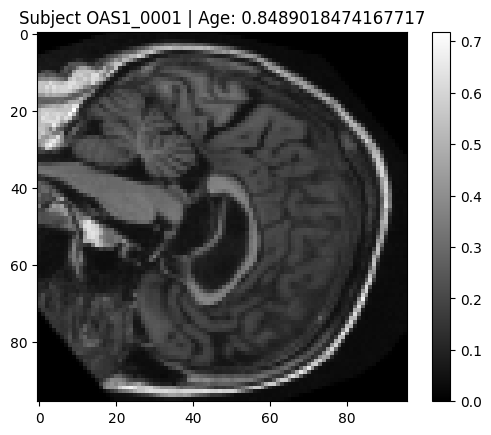

   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔹 Batch 50: Loss = 0.7375
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([3, 1]), Target shape: torch.Size([3])
📅 Epoch 3/20 | 🏋️ Train Loss: 1.1257 | 🧪 Val Loss: 0.9326
⏸️ No improvement for 1 epoch(s)

🔁 Starting epoch 4/20
✅ First batch loaded from tra

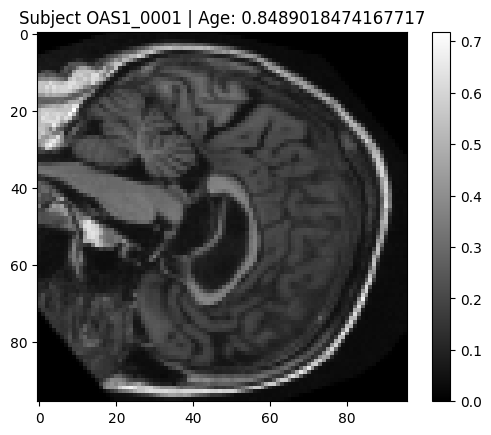

   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔹 Batch 20: Loss = 1.8645
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 Output shape: torch.Size([4, 1]), Target shape: torch.Size([4])
   🔍 

KeyboardInterrupt: 

In [17]:
trainer = BrainAgeTrainer(
    model, train_loader, val_loader,
    criterion, optimizer, device,
    augment=False
)

trainer.train(epochs=20, track_predictions=True)


In [ ]:
history = trainer.get_history()
train_pred, train_true = trainer.get_predictions()['train']
val_pred, val_true = trainer.get_predictions()['val']

# 7.) Eval Setup

In [ ]:
evaluator = BrainAgeEvaluator(model, device)
metrics, y_pred, y_true = evaluator.evaluate(test_loader, criterion)

In [ ]:
train_metadata_df = df.iloc[train_dataset.indices].reset_index(drop=True)
val_metadata_df   = df.iloc[val_dataset.indices].reset_index(drop=True)
test_metadata_df  = df.iloc[test_dataset.indices].reset_index(drop=True)

train_pred, train_true = trainer.get_predictions()['train']
val_pred, val_true     = trainer.get_predictions()['val']

In [ ]:
# Convert to NumPy arrays
train_pred = np.array(train_pred)
train_true = np.array(train_true)
val_pred = np.array(val_pred)
val_true = np.array(val_true)

# Denormalize
train_pred_real = train_pred * std_age + mean_age
train_true_real = train_true * std_age + mean_age

val_pred_real = val_pred * std_age + mean_age
val_true_real = val_true * std_age + mean_age

In [ ]:
evaluator = BrainAgeEvaluator(model, device, metadata_df=train_metadata_df, mean=mean_age, std=std_age)

In [ ]:
# 📊 Compute Metrics on Train Set
train_metrics = evaluator.compute_metrics(train_true_real, train_pred_real)
print("📘 Train Set Metrics:")
print(f"  MAE : {train_metrics['mae']:.2f}")
print(f"  RMSE: {train_metrics['rmse']:.2f}")
print(f"  R²  : {train_metrics['r2']:.3f}")

# 🔄 Switch to Validation Metadata
evaluator.metadata = val_metadata_df

# 📊 Compute Metrics on Validation Set
val_metrics = evaluator.compute_metrics(val_true_real, val_pred_real)
print("\n📗 Validation Set Metrics:")
print(f"  MAE : {val_metrics['mae']:.2f}")
print(f"  RMSE: {val_metrics['rmse']:.2f}")
print(f"  R²  : {val_metrics['r2']:.3f}")

# 📊 Stratified MAE by Demographics
print("\n📊 Stratified MAE by Sex (M/F):")
evaluator.stratify_mae(val_true_real, val_pred_real, by='M/F')

print("\n📊 Stratified MAE by Handedness:")
evaluator.stratify_mae(val_true_real, val_pred_real, by='Hand')

# 📊 Stratified MAE by Brain Volume Bins
print("\n📊 Stratified MAE by nWBV Bins:")
evaluator.stratify_by_volume_bins(val_true_real, val_pred_real, col='nWBV')

print("\n📊 Stratified MAE by eTIV Bins:")
evaluator.stratify_by_volume_bins(val_true_real, val_pred_real, col='eTIV')

In [ ]:
# 📈 Plots
evaluator.plot_train_vs_test(
    train_true_real, train_pred_real,
    val_true_real, val_pred_real
)

evaluator.metadata = val_metadata_df
evaluator.plot_by_cdr_status(val_true_real, val_pred_real, dataset_label="Validation")

evaluator.compare_train_test_metrics(
    train_true_real, train_pred_real,
    val_true_real, val_pred_real
)

In [ ]:
print(df.columns)
print(df[['SubjectID', 'Age']].head())


In [ ]:
img_tensor, age = full_dataset[1]  # Try a different index
mid_slice = img_tensor[0, img_tensor.shape[1] // 2].numpy()

import matplotlib.pyplot as plt
plt.imshow(mid_slice, cmap='gray')
plt.title(f"Age (raw): {age.item():.2f}")
plt.colorbar()
plt.show()



In [ ]:
# 🔍 Evaluate on Test Set
evaluator.metadata = test_metadata_df
test_metrics, test_pred, test_true = evaluator.evaluate(test_loader, criterion)

# Denormalize
test_pred_real = test_pred * std_age + mean_age
test_true_real = test_true * std_age + mean_age

# Print metrics
print("\n📕 Test Set Metrics:")
print(f"  MAE : {test_metrics['mae']:.2f}")
print(f"  RMSE: {test_metrics['rmse']:.2f}")
print(f"  R²  : {test_metrics['r2']:.3f}")
